# Graph contraction with Julia

In [1]:
] add StatsBase

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


In [2]:
using Graphs
using GraphPlot
using StatsBase
include("/home/aschulz/Documents/mcnf_gcn/src/julia/mcnf_gcn/mcnf.jl")
using .MCNFs
using DataFrames

## Loading MCNF instance

In [3]:
instance_path = "/home/aschulz/Documents/huawei_project/multiflow/instances/MCF_data/N600/"

"/home/aschulz/Documents/huawei_project/multiflow/instances/MCF_data/N600/"

Create a MCNF object.

In [4]:
instance = load_mcnf(instance_path)

LoadError: InexactError: Int64(779.8)

## Representing MCNF instances
Let us first define a `MCNF` type that will contain the description of a Multi Commodity Network Flow instance. The type will contain a graph `G` and a set of demands `K`.

### Graph

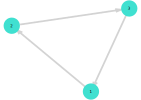

In [5]:
G = SimpleDiGraph(3)
add_edge!(G,1,2)
add_edge!(G,2,3)
add_edge!(G,3,1)

gplot(G, nodelabel=1:3)

In [6]:
typeof(G)

SimpleDiGraph{Int64}

### Demands
Demands are stored in an array with size $(|K|, 3)$.

In [7]:
a = Array{Int64,2}(undef, 10, 3)
println(a)
size(a)
println(a[1,:])


[0 0 140005272531040; 0 0 0; 0 0 0; 0 0 0; 0 0 0; 0 0 0; 0 0 0; 0 0 0; 0 0 0; 0 140005272531040 0]
[0, 0, 140005272531040]


Generating a random set of demands.

In [8]:
function random_demands(graph::SimpleDiGraph{Int64}, n_demands::Int64, volumes::Array{Int64}) 
    nodes = collect(vertices(graph))
    demands = Array{Int64,2}(undef, n_demands, 3)
    for i in 1:n_demands
        demands[i,1:2] = sample(nodes, 2, replace=false)
        demands[i,3] = sample(volumes) 
    end
    return demands
end

rd = random_demands(G, 10, collect(1:100))

10×3 Matrix{Int64}:
 3  1  23
 3  1  54
 1  2  60
 2  3  95
 2  3  31
 1  3  35
 1  2  94
 2  1  24
 1  2  39
 1  2  14

## MCNF type definition

In [9]:
struct MCNF
    G::SimpleDiGraph{Int64}
    cost_map::Dict{Int64,Float64}
    capacity_map::Dict{Int64,Float64}
    K::Array{Int64,2}
end

In [10]:
function random_mcnf(graph::SimpleDiGraph{Int64}, n_demands::Int64, volumes::Array{Int64})
    # cost function
    costs = Dict{Int64,Float64}()
    capacities = Dict{Int64,Float64}()
    for v in vertices(graph)
        costs[v] = 1.
        capacities[v] = 1.
    end
    return MCNF(graph, costs, capacities, random_demands(graph, n_demands, volumes))
end

random_mcnf (generic function with 1 method)

In [11]:
mcnf = random_mcnf(G, 5, collect(1:100))

MCNF(SimpleDiGraph{Int64}(3, [[2], [3], [1]], [[3], [1], [2]]), Dict(2 => 1.0, 3 => 1.0, 1 => 1.0), Dict(2 => 1.0, 3 => 1.0, 1 => 1.0), [1 3 78; 3 1 80; … ; 1 2 98; 2 3 34])

In [12]:
function draw_mcnf(mcnf::MCNF)
    return gplot(mcnf.G, nodelabel=collect(vertices(mcnf.G)))
end

draw_mcnf (generic function with 1 method)

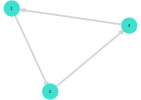

In [13]:
draw_mcnf(mcnf)

## Exact contraction


Creating a subgraph of $G$ from a set of nodes $S \subset V$. The `subgraph` function takes a graph `graph` and a list of nodes `nodes` and returns a tuple `(new_graph, node_dict)` where `new_graph` is a graph object and `node_dict` is a dictionary mapping nodes in `new_graph` to nodes in `graph`.

In [14]:
function subgraph(graph, nodes)
    new_graph = SimpleDiGraph(length(nodes))
    node_dict = Dict()
    c=1
    for n in nodes
        node_dict[n] = c
        c += 1
    end
    for e in edges(graph)
        if (src(e) in nodes) & (dst(e) in nodes)
            add_edge!(new_graph, node_dict[src(e)], node_dict[dst(e)])
        end
    end
    return new_graph, node_dict
end

subgraph (generic function with 1 method)

Create a graph `G1` containing chains that can be contracted. After contraction `G1` will have 3 nodes, the three edges `(1,4), (2,5), (3,6)` will be removed.

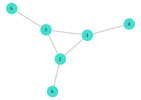

In [15]:
G1 = Graph(6)
add_edge!(G1, 1,2)
add_edge!(G1, 2,3)
add_edge!(G1, 3,1)
add_edge!(G1, 4,1)
add_edge!(G1, 5,2)
add_edge!(G1, 6,3)

gplot(G1, nodelabel=1:6)


Node dict : Dict{Any, Any}(2 => 2, 3 => 3, 1 => 1)
Nodes     : [1, 2, 3]


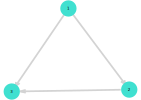

In [16]:
# Testing the subgraph function
(G2, node_dict) = subgraph(G1, [1,2,3])
println("Node dict : ", node_dict)
println("Nodes     : ", collect(vertices(G2)))
gplot(G2, nodelabel=[1,2,3])

Node dict : Dict{Any, Any}(5 => 2, 4 => 1, 6 => 3)
Nodes     : [1, 2, 3]


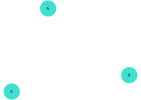

In [17]:
(G3, node_dict) = subgraph(G1, [4,5,6])
println("Node dict : ", node_dict)
println("Nodes     : ", collect(vertices(G3)))
gplot(G3, nodelabel=[4,5,6])

Function that returns all nodes that have degree greater than 2.

In [18]:
function nodes_with_degree_greater_than_2(graph)
    # remove all nodes that have degree greater then 2
    degrees = degree(graph)
    a = []
    for i in enumerate(degrees)
        if i[2] > 2
            append!(a,[i[1]])
        end
    end
    return a
end

nodes_with_degree_greater_than_2 (generic function with 1 method)

In [19]:
l = nodes_with_degree_greater_than_2(G1)
println("Nodes with degree greater than 2 : ", l)

Nodes with degree greater than 2 : Any[1, 2, 3]


Listing neighbors of a component of a graph.

In [20]:
function component_neighbors(graph, component)
    a = []
    for v in component
        for n in neighbors(graph, v)
            if !(n in component)
                append!(a, [n])
            end
        end
    end
    return Set(a[:])
end

component_neighbors (generic function with 1 method)

In [21]:
component = [1,2,3]
l = component_neighbors(G1, component)
println("Component neighbors : ", l)

Component neighbors : Set(Any[5, 4, 6])


## Exact contraction

In [22]:
function reverse_dict(d)
    a = Dict()
    for (key,val) in d
        a[val] = key
    end
    return a
end

function exact_contraction(mcnf::MCNF)
    # remove all nodes that have degree greater then 2
    all_nodes = collect(vertices(mcnf.G))
    keep_nodes = nodes_with_degree_greater_than_2(mcnf.G)
    new_G,new_G_node_dict = subgraph(mcnf.G, keep_nodes)
    new_G_node_dict_rev = reverse_dict(new_G_node_dict)
    
    println("all_nodes $all_nodes")
    println("keep_nodes $keep_nodes")
    println(setdiff(all_nodes, keep_nodes))
    subG,subG_node_dict = subgraph(mcnf.G, setdiff!(all_nodes, keep_nodes))
    subG_node_dict_rev = reverse_dict(subG_node_dict)
    node_chain_map = Dict()
    edge_chain_map = Dict()
    # iterate over connected components
    for c in connected_components(subG)
        cc = []
        for no in c
            append!(cc, subG_node_dict_rev[no])
        end
        println("component ", cc)
        println(c)
        ns = component_neighbors(mcnf.G, cc)
        println("\tneighs ", ns)
        println("\tn neighs ", length(ns))
        if length(ns)==1
            # remove it add chain to map
            println("single neighbor ", cc, ns, collect(ns)[1])
            node_chain_map[collect(ns)[1]] = cc
        else
            # replace chain by an arc
            a = collect(ns)
            println("add edge ", a[1], a[2])
            #add_edge!(new_G, new_G_node_dict_rev[ns[1]], new_G_node_dict_rev[ns[2]])
            #edge_chain_map[(ns[1],ns[2])] = cc
        end
        
    end
    #return new_G, new_G_node_dict, node_chain_map, edge_chain_map
    
end

mcnf1 = random_mcnf(G1, 5, collect(1:100))
exact_contraction(mcnf1)

LoadError: MethodError: no method matching random_mcnf(::SimpleGraph{Int64}, ::Int64, ::Vector{Int64})
[0mClosest candidates are:
[0m  random_mcnf([91m::SimpleDiGraph{Int64}[39m, ::Int64, ::Array{Int64}) at In[10]:1

In [23]:
s1=Set([1,2,3,3])
s2=Set([2,3,4])
setdiff(s2,s1)

Set{Int64} with 1 element:
  4

In [24]:
] add SimpleWeightedGraphs



LoadError: syntax: unexpected "]"

In [25]:
] add SparseArrays

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


In [26]:
using SimpleWeightedGraphs
using SparseArrays

In [27]:
graph1 = SimpleWeightedDiGraph{Int64,Vector{Float64}}(3)
add_edge!(graph1,1,2,[1., 2.])
add_edge!(graph1,2,3,[1., 3.])
add_edge!(graph1,3,1,[1., 4.])
println(graph1.weights)
println(sparse(transpose(Array(graph1.weights))))


LoadError: TypeError: in SimpleWeightedDiGraph, in U, expected U<:Real, got Type{Vector{Float64}}